# Telecom Churn Prediction

**Author:** Sunny Kumar

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

- Data Understanding and Data Preparation
- Exploratory data analysis (EDA)
- Training the model
- Model Prediction and Evaluation
- Recommandations

## Data Understanding and Data Preparation

### Data Understanding and Data Preparation

In [976]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import IncrementalPCA

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

### Load dataset

In [977]:
#Load data set
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")


In [978]:
# Inspect dimension
print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [979]:
# Statistics summary of the train dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,69999.0,34999.000000,20207.115084,0.0,17499.5,34999.0,52498.5,69998.00
circle_id,69999.0,109.000000,0.000000,109.0,109.0,109.0,109.0,109.00
loc_og_t2o_mou,69297.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
std_og_t2o_mou,69297.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
loc_ic_t2o_mou,69297.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...
aon,69999.0,1220.639709,952.426321,180.0,468.0,868.0,1813.0,4337.00
aug_vbc_3g,69999.0,68.108597,269.328659,0.0,0.0,0.0,0.0,12916.22
jul_vbc_3g,69999.0,65.935830,267.899034,0.0,0.0,0.0,0.0,9165.60
jun_vbc_3g,69999.0,60.076740,257.226810,0.0,0.0,0.0,0.0,11166.21


### Data preparation

Assumption:
**three phases of customer lifecycle :**
- The ‘good’ phase
- The ‘action’ phase 
- The ‘churn’ phase 

Please refer problem statement for more information.


In [980]:
#Extracting list of columns containing recharge amount
recharge_columns =  data.columns[data.columns.str.contains('rech_amt|rech_data')]
print(recharge_columns,"\n")
print("The are in total",len(recharge_columns),"Columns containing Recharge Amount")

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8'],
      dtype='object') 

The are in total 18 Columns containing Recharge Amount


In [981]:
#Checking missing values percentages
null_check = 100*data.loc[:,recharge_columns].isnull().sum()/len(data)
null_check = null_check.round(decimals = 2)
null_check

total_rech_amt_6             0.00
total_rech_amt_7             0.00
total_rech_amt_8             0.00
max_rech_amt_6               0.00
max_rech_amt_7               0.00
max_rech_amt_8               0.00
date_of_last_rech_data_6    74.90
date_of_last_rech_data_7    74.48
date_of_last_rech_data_8    73.69
total_rech_data_6           74.90
total_rech_data_7           74.48
total_rech_data_8           73.69
max_rech_data_6             74.90
max_rech_data_7             74.48
max_rech_data_8             73.69
av_rech_amt_data_6          74.90
av_rech_amt_data_7          74.48
av_rech_amt_data_8          73.69
dtype: float64

##### Observations : For most of the columns more then `74%` values for **recharge** related data are missing.

In [982]:
#Replacing the NAN values with 0, considering there were no recharges done by the customer.
data['total_rech_data_6'] = data['total_rech_data_6'].replace(np.nan,0.0)
data['total_rech_data_7'] = data['total_rech_data_7'].replace(np.nan,0.0)
data['total_rech_data_8'] = data['total_rech_data_8'].replace(np.nan,0.0)
data['av_rech_amt_data_6'] = data['av_rech_amt_data_6'].replace(np.nan,0.0)
data['av_rech_amt_data_7'] = data['av_rech_amt_data_7'].replace(np.nan,0.0)
data['av_rech_amt_data_8'] = data['av_rech_amt_data_8'].replace(np.nan,0.0)

In [983]:
#let's adding new column total recharge amount for data: total_rech_amt_data for calculating High Value customer process
data['total_rech_amt_data_6'] = data.av_rech_amt_data_6 + data.total_rech_data_6
data['total_rech_amt_data_7'] = data.av_rech_amt_data_7 + data.total_rech_data_7
data['total_rech_amt_data_8'] = data.av_rech_amt_data_8 + data.total_rech_data_8

In [984]:
#Defining total average recharge amount for good phase for months 6 and 7 (the good phase)
data['total_avg_rech_amnt_6_7_GPhase'] = (data.total_rech_amt_6 + data.total_rech_amt_data_6+ data.total_rech_amt_7+ data.total_rech_amt_data_7)/2

##### FILTER: - *Those who have recharged with an amount more than or equal to X, where X is greater than 70th percentile of the average recharge amount in the first two months (the good phase)*

In [985]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = data.total_avg_rech_amnt_6_7_GPhase.quantile(0.7)
print('70 percentile of 6th and 7th months avg recharge amount: '+str(high_value_filter),"\n")

telecom_df_high_val_cust = data[data.total_avg_rech_amnt_6_7_GPhase > high_value_filter]
print('Dataframe Shape after Filtering High Value Customers: ' + str(telecom_df_high_val_cust.shape),"\n")

70 percentile of 6th and 7th months avg recharge amount: 432.5 

Dataframe Shape after Filtering High Value Customers: (20984, 176) 



In [986]:
#taking all the mentioned columns in a dataframe
high_val_cust_8 = ['total_ic_mou_8', 'total_og_mou_8', 'vol_2g_mb_8','vol_3g_mb_8']

In [987]:
# Checking the NA/Null values are present or Not
df = 100*telecom_df_high_val_cust.loc[:,high_val_cust_8].isnull().sum()/len(telecom_df_high_val_cust)
df

total_ic_mou_8    0.0
total_og_mou_8    0.0
vol_2g_mb_8       0.0
vol_3g_mb_8       0.0
dtype: float64

In [988]:
# Initially set all the values as 0
telecom_df_high_val_cust['churn']= 0

In [989]:
#is_churned boolean flag for customers where above values are zero
is_churned = (telecom_df_high_val_cust.total_ic_mou_8 == 0) & \
             (telecom_df_high_val_cust.total_og_mou_8 == 0) & \
             (telecom_df_high_val_cust.vol_2g_mb_8 ==0) & \
             (telecom_df_high_val_cust.vol_3g_mb_8 ==0)
# set all which having is_churned True condition as 1
telecom_df_high_val_cust.loc[is_churned,'churn']=1

In [990]:
# let us check what's the % of churned customers
print("The Percentage of Churned Customers are",round(100*telecom_df_high_val_cust.churn.sum()/len(telecom_df_high_val_cust),2),"%")

The Percentage of Churned Customers are 5.47 %


In [991]:
telecom_df_high_val_cust

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
12,12,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,439.919,397.946,...,322,0.00,0.00,0.00,0,0.0,0.0,0.0,469.5,0
15,15,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,580.549,377.294,...,602,0.00,0.00,0.00,0,155.0,0.0,155.0,604.5,0
23,23,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1130.948,905.506,...,455,0.00,0.00,0.00,0,0.0,0.0,0.0,1205.0,0
24,24,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,371.974,352.069,...,1219,0.00,0.00,0.00,0,24.0,48.0,24.0,469.5,0
27,27,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,390.489,350.985,...,573,700.40,185.71,173.72,0,209.0,306.0,217.0,826.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69982,69982,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,146.927,458.054,...,1577,0.00,0.00,0.00,0,0.0,276.0,0.0,449.0,0
69984,69984,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1106.130,1609.381,...,283,6.48,102.80,127.41,0,452.0,0.0,0.0,1624.0,0
69989,69989,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,196.695,298.645,...,251,107.77,112.70,242.18,0,101.0,234.0,92.0,483.5,0
69996,69996,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,372.088,258.374,...,879,0.00,0.00,0.00,0,0.0,0.0,0.0,438.0,0


## Exploratory data analysis (EDA)

In [992]:
for i in telecom_df_high_val_cust.columns :
    if len(pd.unique(telecom_df_high_val_cust[i])) == 2:
        print(i," - ",len(pd.unique(telecom_df_high_val_cust[i])))

loc_og_t2o_mou  -  2
std_og_t2o_mou  -  2
loc_ic_t2o_mou  -  2
last_date_of_month_7  -  2
last_date_of_month_8  -  2
std_og_t2c_mou_6  -  2
std_og_t2c_mou_7  -  2
std_og_t2c_mou_8  -  2
std_ic_t2o_mou_6  -  2
std_ic_t2o_mou_7  -  2
std_ic_t2o_mou_8  -  2
churn_probability  -  2
churn  -  2


In [993]:
drop_col_with_unique_col =['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 
                          'last_date_of_month_6', 'last_date_of_month_7',
                          'std_og_t2c_mou_6', 'std_og_t2c_mou_7','std_ic_t2o_mou_6', 
                          'std_ic_t2o_mou_7']

In [994]:
print("Features before dropping unique values : "+ str(telecom_df_high_val_cust.shape[1]))
telecom_df_high_val_cust.drop(drop_col_with_unique_col,axis=1,inplace=True)
print("Features after dropping unique values : "+ str(telecom_df_high_val_cust.shape[1]))

Features before dropping unique values : 177
Features after dropping unique values : 167


In [995]:
df_DateCols = []
for i in telecom_df_high_val_cust.columns :
    if telecom_df_high_val_cust[i].dtypes == 'object':
        print(i," - ",telecom_df_high_val_cust[i].dtypes)
        df_DateCols.append(i)
df_DateCols

last_date_of_month_8  -  object
date_of_last_rech_6  -  object
date_of_last_rech_7  -  object
date_of_last_rech_8  -  object
date_of_last_rech_data_6  -  object
date_of_last_rech_data_7  -  object
date_of_last_rech_data_8  -  object


['last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [996]:
#Since all the Object Type Columns are of DateType , lets convert them to Date Type
for col in df_DateCols:
    telecom_df_high_val_cust[col] = pd.to_datetime(telecom_df_high_val_cust[col])

### Observe Features with Graghs and Charts

In [997]:
# create box plot function for  6th, 7th and 8th month variables
def plot_box_chart(attribute):
    plt.figure(figsize=(20,16))
    df = telecom_df_high_val_cust
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn",hue="churn",
                showfliers=False)
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn",hue="churn",
                showfliers=False)
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn",hue="churn",
                showfliers=False)
    plt.show()

## 1. Recharge amount related Features

In [998]:
#Lets extract the columns containing recharge amount in their variable name
recharge_amnt_columns =  telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('rech_amt')]
recharge_amnt_columns.tolist()

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_amt_data_6',
 'total_rech_amt_data_7',
 'total_rech_amt_data_8']

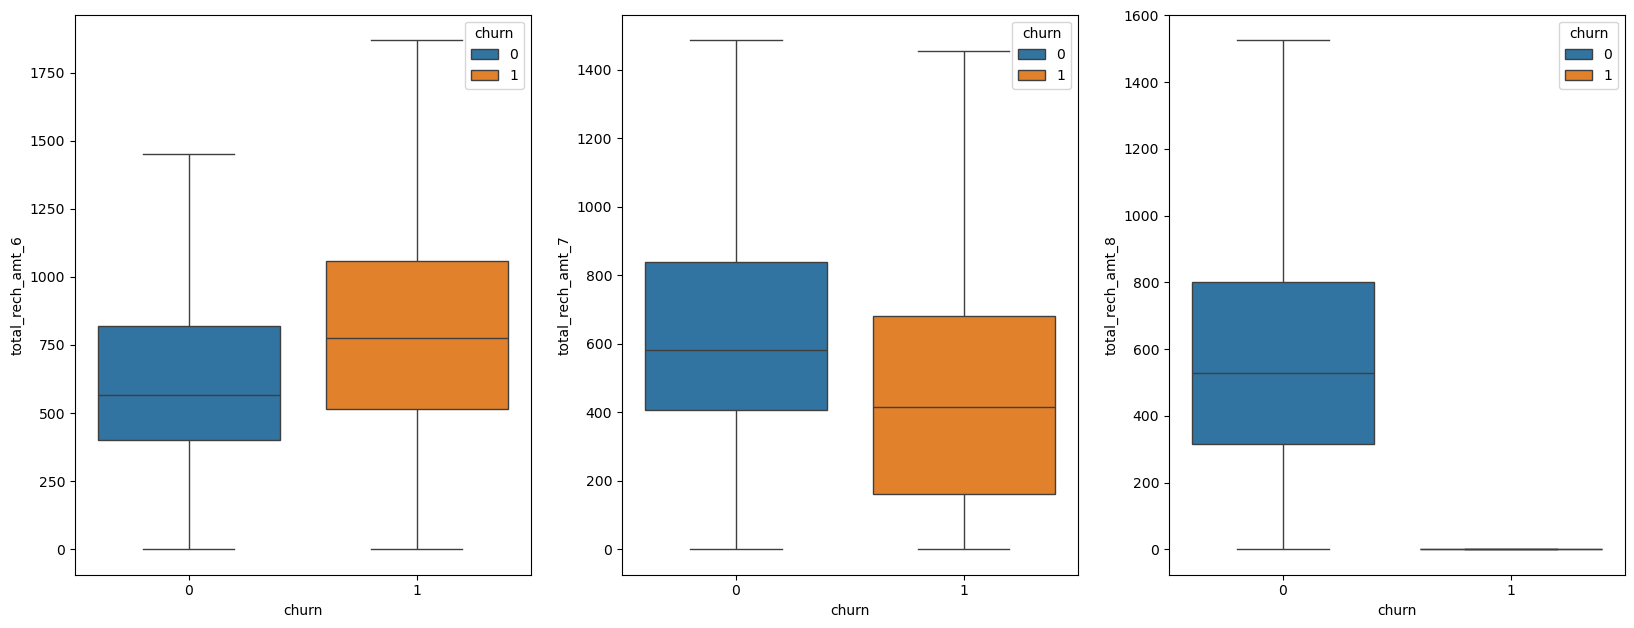

In [999]:
# Ploting for total recharge amount:
plot_box_chart('total_rech_amt')

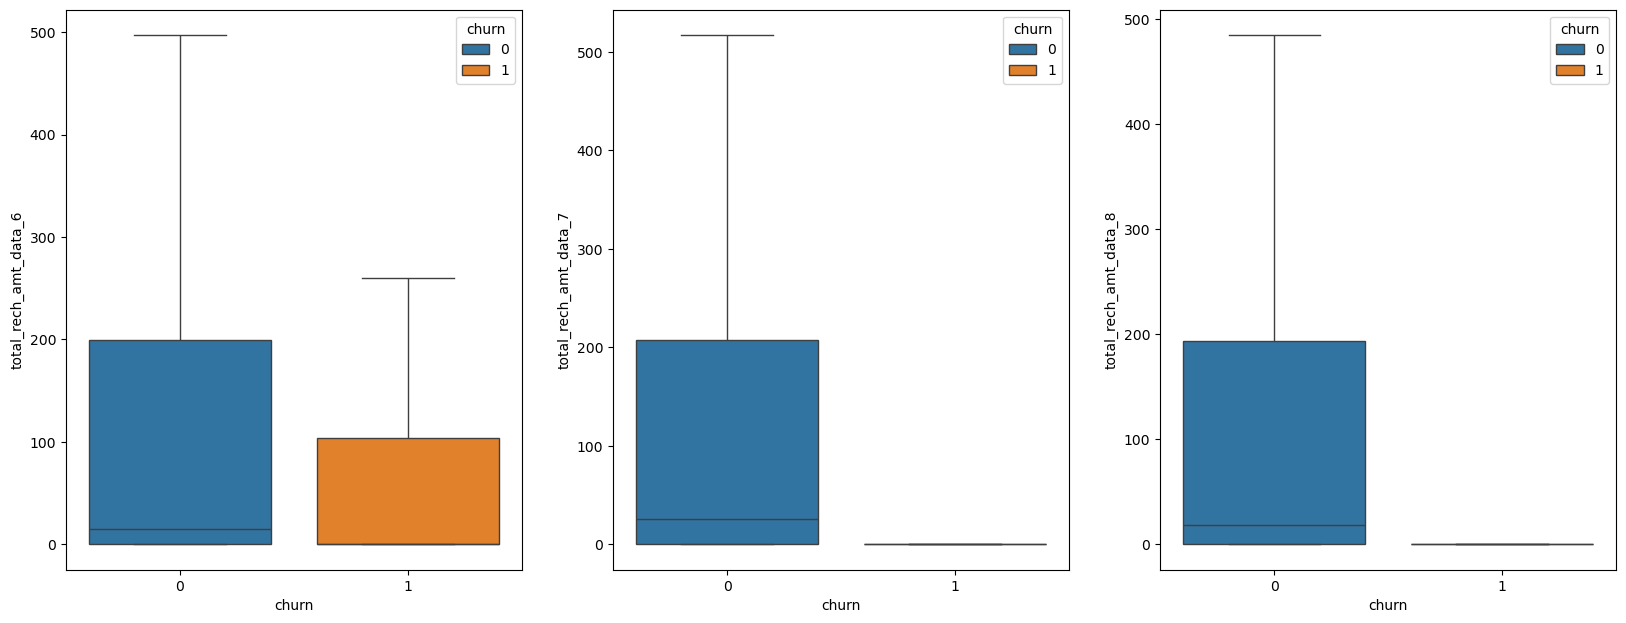

In [1000]:
# Ploting for total recharge amount for data:
plot_box_chart('total_rech_amt_data')

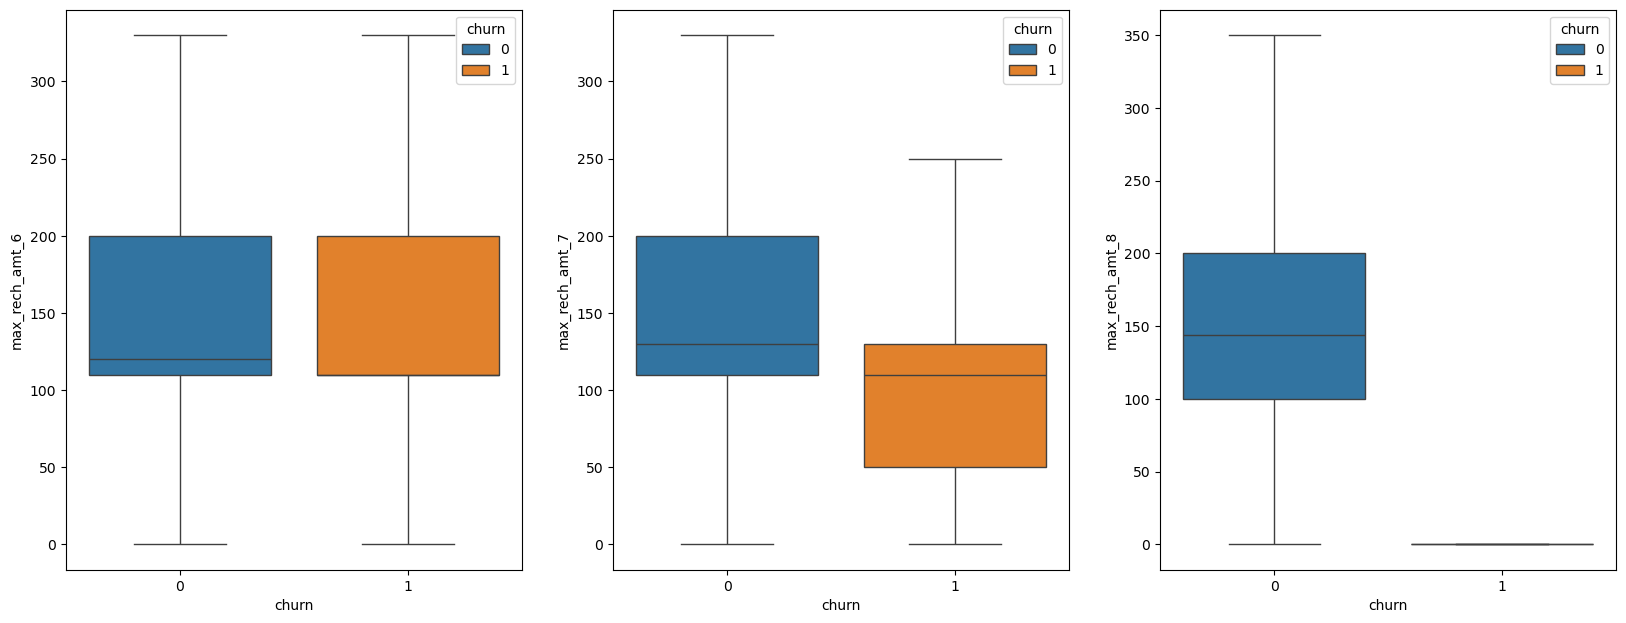

In [1001]:
# Ploting for maximum recharge amount for data:
plot_box_chart('max_rech_amt')

##### Observations : We can see that there is a huge drop in maximum recharge amount for data in the 8th month (action phase) for churned customers.

In [1002]:
#Some other recharge related variables:
other_recharge = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('rech_num|max_rech_data',regex=True)]

In [1003]:
# lets check the percentage of Null values for other recharge related variables
100*telecom_df_high_val_cust.loc[:,other_recharge].isnull().sum()/len(telecom_df_high_val_cust)

total_rech_num_6     0.000000
total_rech_num_7     0.000000
total_rech_num_8     0.000000
max_rech_data_6     50.443195
max_rech_data_7     49.428136
max_rech_data_8     51.725124
dtype: float64

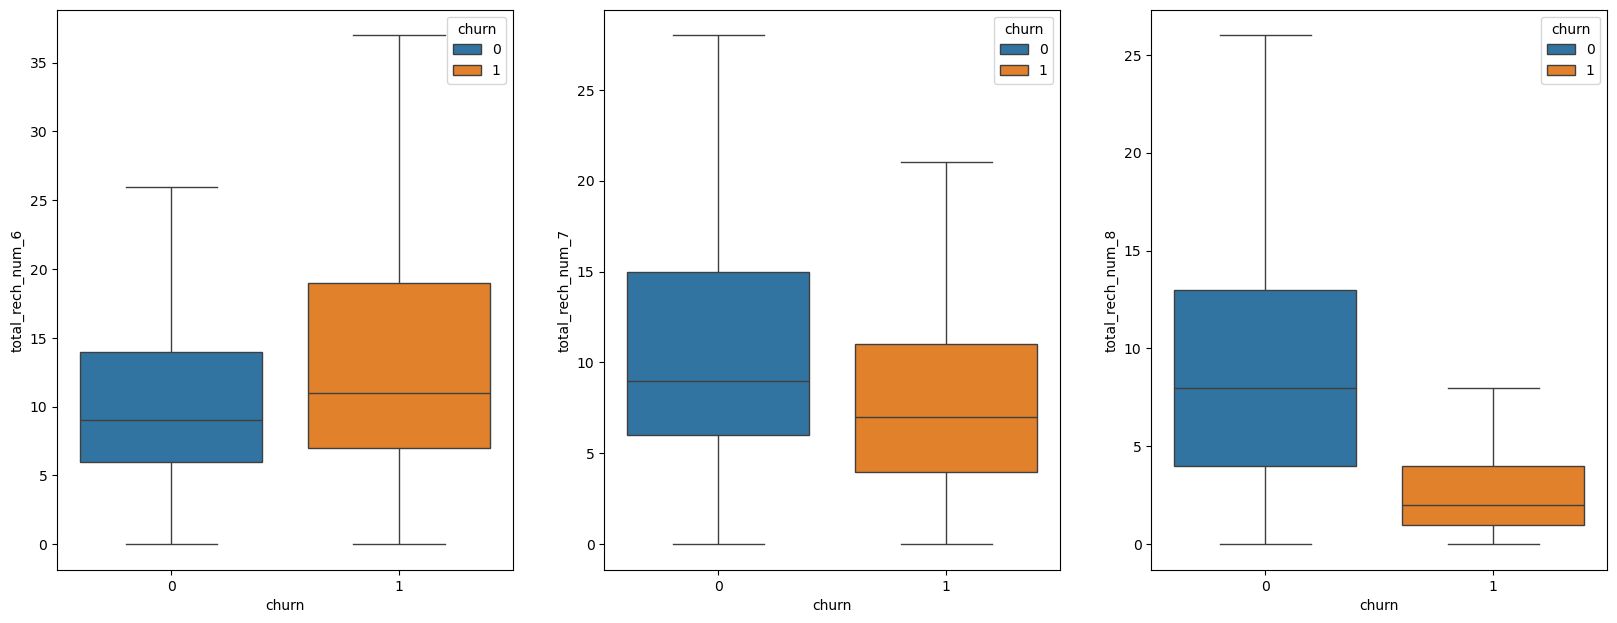

In [1004]:
#Ploting for Total recharge for Number:
plot_box_chart('total_rech_num')

##### Observations : We can see that there is a huge drop in total recharge number also in the 8th month (action phase) for churned customers.

In [1005]:
#Replace null values of max_rech_data with 0
telecom_df_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']] = telecom_df_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].replace(np.nan,0)

In [1006]:
100*telecom_df_high_val_cust.loc[:,other_recharge].isnull().sum()/len(telecom_df_high_val_cust)

total_rech_num_6    0.0
total_rech_num_7    0.0
total_rech_num_8    0.0
max_rech_data_6     0.0
max_rech_data_7     0.0
max_rech_data_8     0.0
dtype: float64

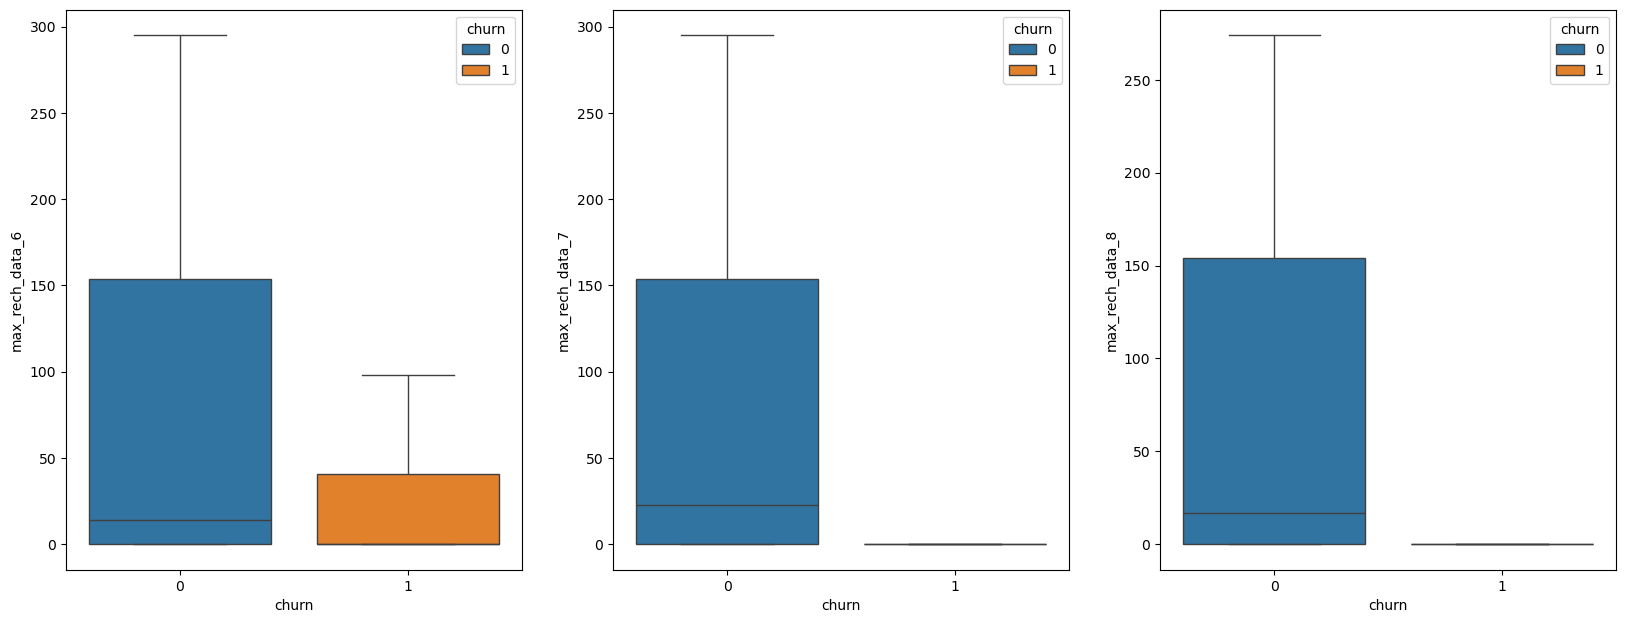

In [1007]:
# Ploting for maximum recharge for data:
plot_box_chart('max_rech_data')

In [1008]:
#Extracting the last day recharge amount columns
last_day_rech_amt = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('day')]
print(last_day_rech_amt)

Index(['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8'], dtype='object')


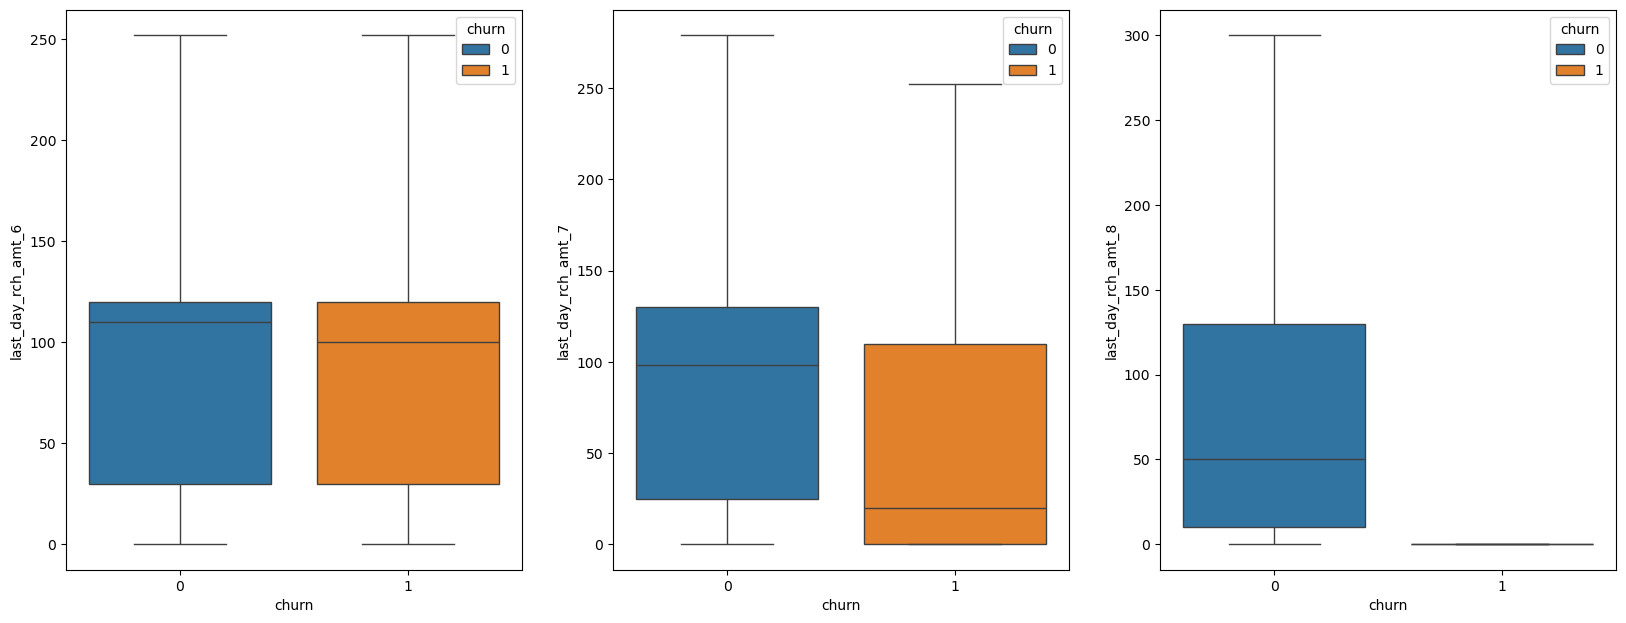

In [1009]:
# Ploting for last day recharge amount:
plot_box_chart('last_day_rch_amt')

#### Data usage related Features

In [1010]:
usage_2g_and_3g = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('2g|3g',regex=True)]

In [1011]:
#Lets drop the columns with more than 49% data as null
telecom_df_high_val_cust.drop(['count_rech_2g_6','count_rech_2g_7',
              'count_rech_3g_6','count_rech_3g_7',
            'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis=1,inplace=True)

In [1012]:
telecom_df_high_val_cust.shape

(20984, 157)

#### Volume based cost usage related Features

In [1013]:
vbc_column = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('vbc_',regex=True)]
vbc_column.tolist()

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']

In [1014]:
# Renaming month named vbc columns to 6,7,8 format
telecom_df_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'}, inplace=True)

In [1015]:
vbc_column = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('vbc_3g',regex=True)]
vbc_column.tolist()

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']

#### voice calls  related Features

In [1016]:
mou = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('mou')]

In [1017]:
mou

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_8',
       'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6',
       'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7',
       'spl_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8',
       'loc_ic_t2t_mo

In [1018]:
mou = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('mou')]

In [1019]:
# replaceing null values by 0 for minutes of usage variables
telecom_df_high_val_cust.loc[:,mou] = telecom_df_high_val_cust.loc[:,mou].replace(np.nan,0)

In [1020]:
mou_og_cols6 = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('.*_og_.*mou_6',regex=True)]

In [1021]:
telecom_df_high_val_cust.loc[:,mou_og_cols6].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000
mean,28.558768,88.412276,170.866712,6.647443,1.549121,265.934996,177.757522,192.617813,1.894971,372.274326,2.383451,5.842503,647.098117
std,121.136006,233.410894,249.214341,20.571314,6.563695,380.845586,411.211260,412.078561,12.622126,612.028902,53.090602,19.016429,682.983177
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.137500,24.380000,0.000000,0.000000,41.290000,0.000000,0.000000,0.000000,1.750000,0.000000,0.000000,176.330000
50%,0.000000,28.040000,86.960000,0.260000,0.000000,140.875000,6.020000,24.200000,0.000000,73.010000,0.000000,0.160000,464.255000
75%,0.000000,83.132500,221.032500,4.765000,0.000000,350.777500,140.250000,182.682500,0.000000,535.937500,0.000000,5.015000,885.795000
max,3775.110000,6431.330000,4696.830000,617.580000,271.440000,10643.380000,7366.580000,8314.760000,628.560000,8432.990000,5900.660000,1023.210000,10674.030000


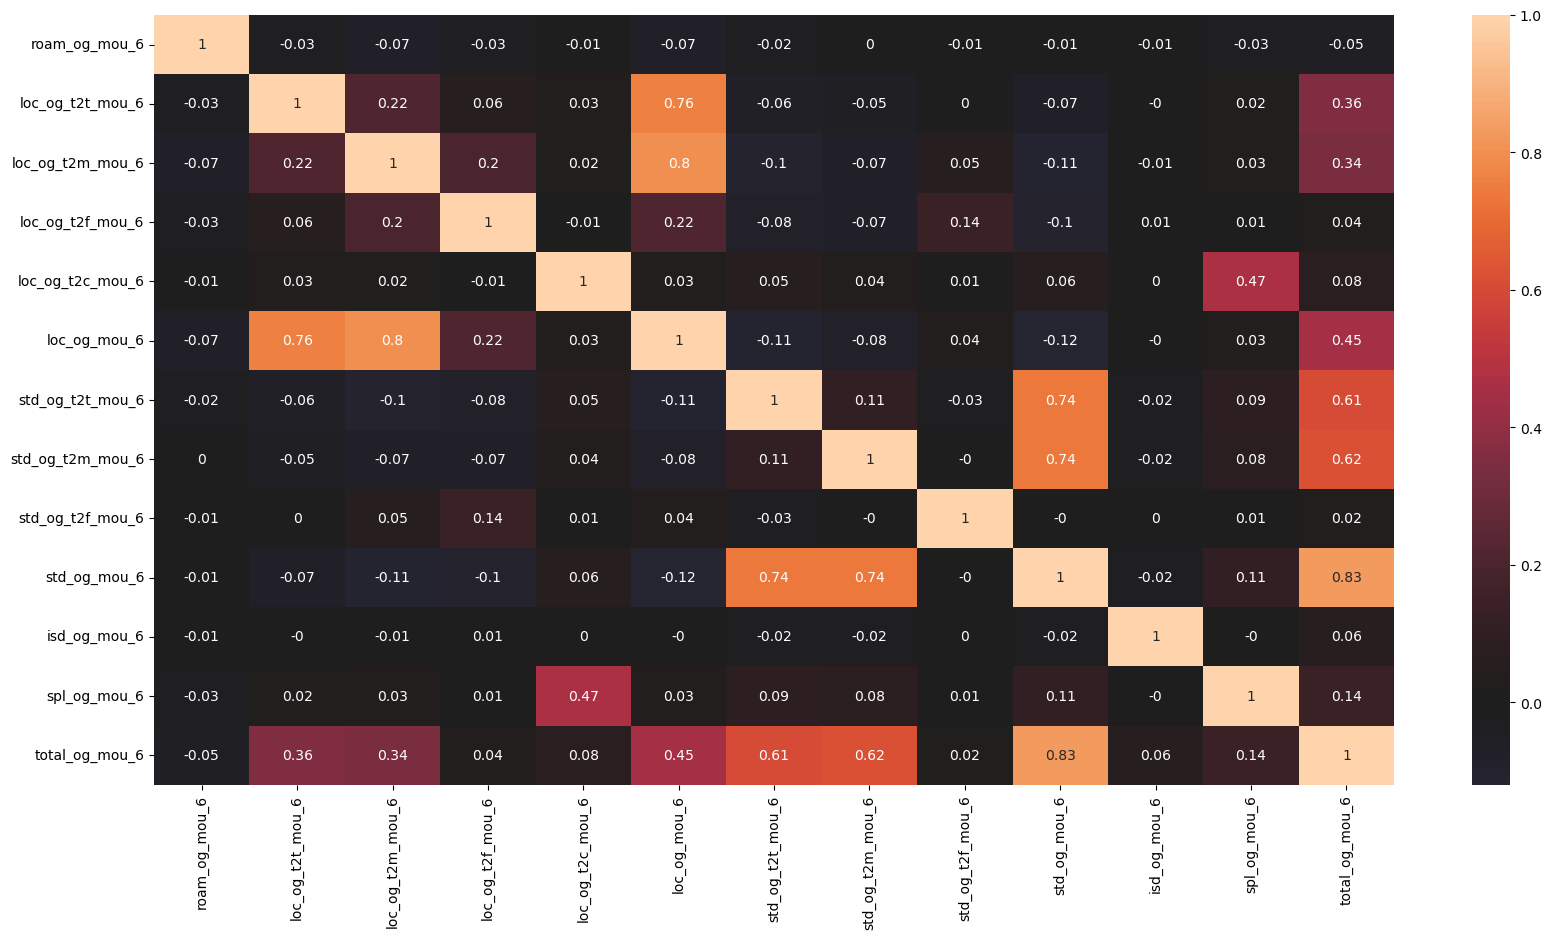

In [1022]:
#Checking the corelation
plt.subplots(figsize = (20,10))
#Plotting heatmap of numerical features
sns.heatmap(round(telecom_df_high_val_cust.filter(mou_og_cols6).corr(),2) , annot=True, center = 0)
plt.show()

In [1023]:
#lets drop columns with total_og_mou|std_og_mou|loc_og_mou
list_total_og_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
telecom_df_high_val_cust.drop(list_total_og_cols,axis=1,inplace=True)
list_total_og_cols.tolist()

['loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8']

In [1024]:
telecom_df_high_val_cust.shape

(20984, 148)

In [1025]:
#Checking for incoming mou variables
mou_ic_cols6 = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('.*_ic_.*mou_6',regex=True)]

In [1026]:
telecom_df_high_val_cust.loc[:,mou_ic_cols6].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.00000,20984.000000,20984.000000,20984.000000,20984.000000
mean,16.611307,66.864156,153.497267,15.755854,236.127060,15.217241,30.273796,2.91167,48.406447,296.683751,0.063772,10.848323
std,77.514092,158.017983,215.644988,45.059876,309.688761,70.835910,95.300274,21.05211,131.480014,357.918139,0.200656,76.904438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.090000,30.660000,0.000000,51.960000,0.000000,0.030000,0.00000,1.600000,80.690000,0.000000,0.000000
50%,0.000000,26.560000,88.225000,2.030000,142.190000,0.630000,5.830000,0.00000,12.885000,194.100000,0.000000,0.000000
75%,0.000000,70.040000,194.345000,12.710000,305.220000,9.195000,25.390000,0.20000,43.980000,381.832500,0.000000,0.000000
max,2613.310000,4363.960000,4450.740000,1373.090000,7454.630000,3038.340000,3613.980000,1351.11000,3929.240000,7716.140000,19.760000,6789.410000


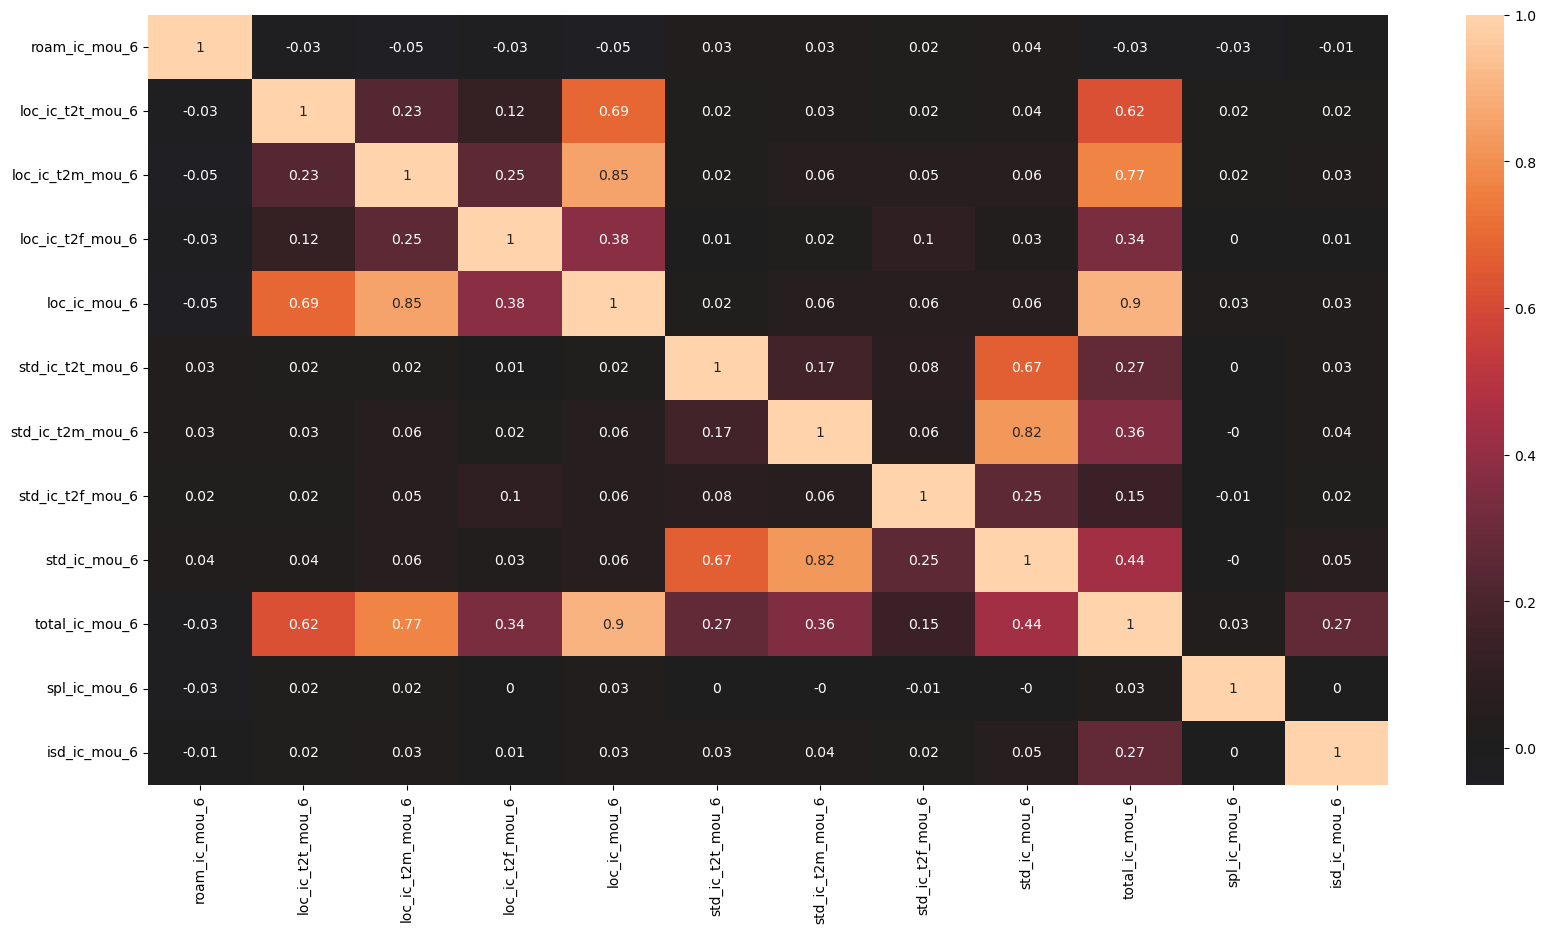

In [1027]:
#Checking the corelation
plt.subplots(figsize = (20,10))
#Plotting heatmap of numerical features
sns.heatmap(round(telecom_df_high_val_cust.filter(mou_ic_cols6).corr(),2) , annot=True, center = 0)
plt.show()

##### Observations : We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues.

In [1028]:
#lets drop columns with total_ic_mou|std_ic_mou|loc_ic_mou
list_total_ic_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
telecom_df_high_val_cust.drop(list_total_ic_cols,axis=1,inplace=True)
list_total_ic_cols.tolist()

['loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8']

In [1029]:
telecom_df_high_val_cust.shape

(20984, 139)

#### Tenure Analysis for Customers 

In [1030]:
tenure_data = telecom_df_high_val_cust.copy()

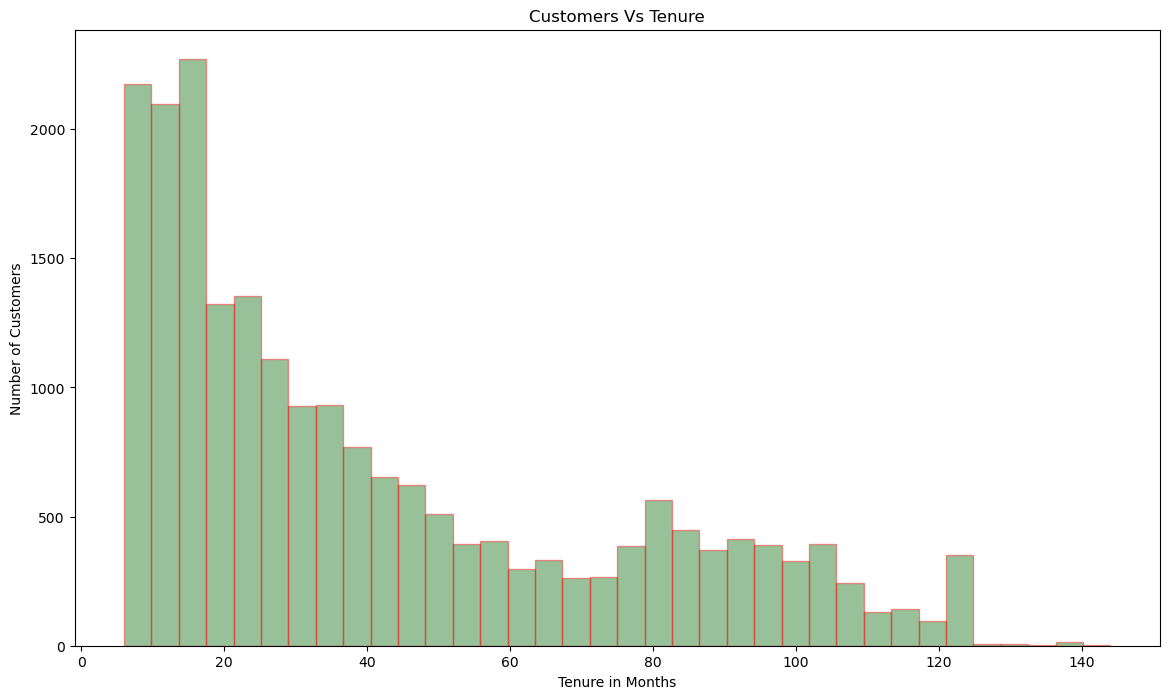

In [1031]:
plt.figure(figsize=(14,8))
# aon --> Age on network - number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()
ax = sns.distplot(tenure_data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

In [1032]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

12    6-12 Months
15        1-2 Yrs
23        1-2 Yrs
24        2-5 Yrs
27        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

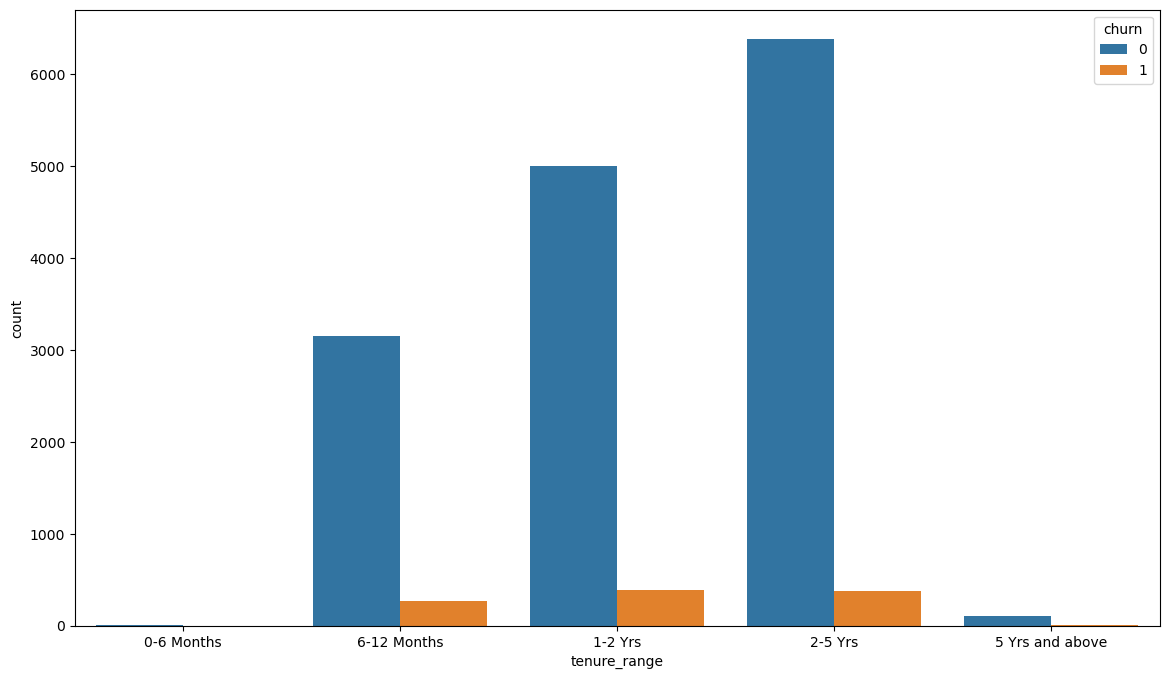

In [1033]:
plt.figure(figsize=(14,8))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data)
plt.show()

#### Checking columns with more than 30% NA values.

In [1034]:
100*telecom_df_high_val_cust.isnull().mean().sort_values(ascending=False)

count_rech_3g_8                   51.725124
date_of_last_rech_data_8          51.725124
night_pck_user_8                  51.725124
fb_user_8                         51.725124
count_rech_2g_8                   51.725124
                                    ...    
total_rech_amt_data_6              0.000000
total_rech_amt_data_7              0.000000
total_rech_amt_data_8              0.000000
total_avg_rech_amnt_6_7_GPhase     0.000000
churn                              0.000000
Length: 139, dtype: float64

In [1035]:
# making list of columns that have high missing values that we want to remove
rmcols=[]
for i in telecom_df_high_val_cust.columns:
    if(telecom_df_high_val_cust[i].isnull().mean()*100>=30.00):
        rmcols.append(i)
        
print("The Below Columns are removed from the Dataset :\n")
print(rmcols)

The Below Columns are removed from the Dataset :

['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']


In [1036]:
telecom_df_high_val_cust.shape

(20984, 139)

In [1037]:
# Removing these columns
telecom_df_high_val_cust.drop(rmcols,axis=1,inplace=True)
telecom_df_high_val_cust.shape# verifying the shape of the dataset

(20984, 128)

In [1038]:
telecom_df_high_val_cust.drop(['max_rech_data_8'], axis=1,inplace=True)

In [1039]:
telecom_df_high_val_cust.shape

(20984, 127)

In [1040]:
numberic_col = [ 'og_others_6','ic_others_6', 'og_others_7', 'ic_others_7']

In [1041]:
#Replacing NaN values with zero for all numeric data as most of the data is clean and will not impact the analysis
for i in numberic_col:
    telecom_df_high_val_cust.loc[telecom_df_high_val_cust[i].isnull(),i]=0

In [1042]:
100*telecom_df_high_val_cust.isnull().mean().sort_values(ascending=False)

og_others_8                       3.678994
ic_others_8                       3.678994
date_of_last_rech_8               1.906214
last_date_of_month_8              0.519443
date_of_last_rech_7               0.328822
                                    ...   
total_rech_amt_data_6             0.000000
total_rech_amt_data_7             0.000000
total_rech_amt_data_8             0.000000
total_avg_rech_amnt_6_7_GPhase    0.000000
churn                             0.000000
Length: 127, dtype: float64

#### Derive new features.

In [1043]:
telecom_df_final = telecom_df_high_val_cust.copy()
print(telecom_df_final.shape)
telecom_df_final.head()

(20984, 127)


,id,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,churn_probability,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
12,12,2014-08-31,439.919,397.946,392.024,244.46,108.31,42.98,571.98,727.91,...,322,0.0,0.00,0.00,0,0.0,0.0,0.0,469.5,0
15,15,2014-08-31,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,...,602,0.0,0.00,0.00,0,155.0,0.0,155.0,604.5,0
23,23,2014-08-31,1130.948,905.506,479.762,859.53,372.71,0.89,293.46,450.11,...,455,0.0,0.00,0.00,0,0.0,0.0,0.0,1205.0,0
24,24,2014-08-31,371.974,352.069,240.449,93.18,38.29,29.86,531.19,507.76,...,1219,0.0,0.00,0.00,0,24.0,48.0,24.0,469.5,0
27,27,2014-08-31,390.489,350.985,421.300,8.58,11.48,12.68,133.16,158.73,...,573,700.4,185.71,173.72,0,209.0,306.0,217.0,826.0,0


In [1044]:
telecom_df_final.drop(["total_avg_rech_amnt_6_7_GPhase"],axis=1,inplace=True)
telecom_df_final.drop(telecom_df_high_val_cust.filter(regex='date_').columns,axis=1,inplace=True)
print (telecom_df_final.shape)

col_list = telecom_df_final.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_df_final[avg_col_name] = (telecom_df_final[col_6]  + telecom_df_final[col_7])/ 2

(20984, 122)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
vbc_3g
total_rech_amt_data


In [1045]:
col_list_to_drop = telecom_df_final.filter(regex='_6|_7')
telecom_df_final.drop(col_list_to_drop,axis=1,inplace=True)
print (telecom_df_final.shape)

(20984, 83)


In [1046]:
telecom_df_final.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
12,12,392.024,42.98,644.43,0.0,0.0,3.98,51.24,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
15,15,338.286,194.43,197.09,0.0,0.0,194.43,185.88,4.94,0.00,...,77.0,77.0,130.21,0.00,0.5,0.0,0.0,0.0,0.000,77.5
23,23,479.762,0.89,386.91,0.0,0.0,0.89,378.01,8.88,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
24,24,240.449,29.86,222.03,0.0,0.0,29.86,99.86,0.00,0.36,...,23.0,34.5,0.02,0.00,0.0,1.5,0.0,0.0,0.000,36.0
27,27,421.300,12.68,182.83,0.0,0.0,12.68,157.23,25.59,0.00,...,153.0,254.5,49.46,325.04,0.5,2.0,0.0,0.5,179.715,257.5


In [1047]:
telecom_df_final.columns

Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_t2c_mou_8',
       'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_t2o_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8',
       'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8',
       'total_rech_data_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8',
       'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon',
       'vbc_3g_8', 'churn_probability', 'total_rech_amt_data_8', 'churn',
       'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67',
       'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_a

##### Observations : We have merged most of the columns related to month 6 & 7 so to reduce the number of features. By doing this apporach we have reduced the fetures from 124 to 84.

## Training the model


In [1048]:
def split_date(df):
    Y = df["churn"]
    X = df.drop(["churn"],axis=1)
    return X,Y
    
def scale_data(X):
    scaler = StandardScaler()
    X_col = X.columns
    X_scaled = scaler.fit_transform(X)
    X_scale_final = pd.DataFrame(X_scaled, columns=X_col)
    print("Scaling the data ....")
    return X_scale_final

def get_scree_plot(X):
    pca = PCA(svd_solver='randomized', random_state=101)
    pca.fit(X)
    fig = plt.figure(figsize = (8,6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    return pca

In [1049]:
telecom_pca_df = telecom_df_final.copy()
telecom_pca_df.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
12,12,392.024,42.98,644.43,0.0,0.0,3.98,51.24,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
15,15,338.286,194.43,197.09,0.0,0.0,194.43,185.88,4.94,0.00,...,77.0,77.0,130.21,0.00,0.5,0.0,0.0,0.0,0.000,77.5
23,23,479.762,0.89,386.91,0.0,0.0,0.89,378.01,8.88,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
24,24,240.449,29.86,222.03,0.0,0.0,29.86,99.86,0.00,0.36,...,23.0,34.5,0.02,0.00,0.0,1.5,0.0,0.0,0.000,36.0
27,27,421.300,12.68,182.83,0.0,0.0,12.68,157.23,25.59,0.00,...,153.0,254.5,49.46,325.04,0.5,2.0,0.0,0.5,179.715,257.5


In [1050]:
#Splitting in x and y
X,Y=split_date(telecom_pca_df)

In [1051]:
X.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
12,12,392.024,42.98,644.43,0.0,0.0,3.98,51.24,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
15,15,338.286,194.43,197.09,0.0,0.0,194.43,185.88,4.94,0.00,...,77.0,77.0,130.21,0.00,0.5,0.0,0.0,0.0,0.000,77.5
23,23,479.762,0.89,386.91,0.0,0.0,0.89,378.01,8.88,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
24,24,240.449,29.86,222.03,0.0,0.0,29.86,99.86,0.00,0.36,...,23.0,34.5,0.02,0.00,0.0,1.5,0.0,0.0,0.000,36.0
27,27,421.300,12.68,182.83,0.0,0.0,12.68,157.23,25.59,0.00,...,153.0,254.5,49.46,325.04,0.5,2.0,0.0,0.5,179.715,257.5


In [1052]:
Y.head(10)

12    0
15    0
23    0
24    0
27    0
33    0
39    0
45    0
49    0
52    0
Name: churn, dtype: int64

In [1053]:
print("Percenatge of Churned Customer data : "+str(round(100*Y.sum()/len(Y),2)))

Percenatge of Churned Customer data : 5.47


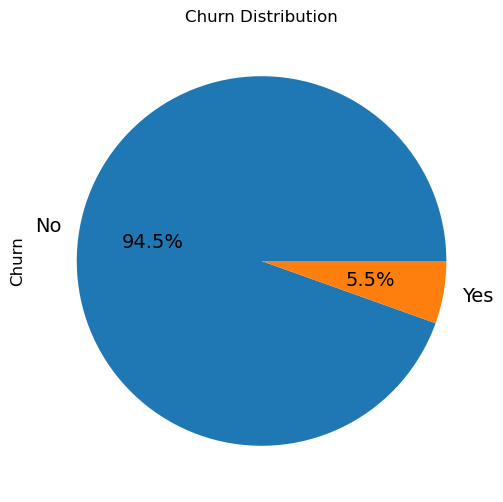

In [1054]:
#Churn Distribution
pie_chart = telecom_pca_df['churn'].value_counts()*100.0 /len(telecom_pca_df)
ax = pie_chart.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(8,6), fontsize = 14 )                                                                           
ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('Churn Distribution', fontsize = 12)
plt.show()

### Scaling the data so as to normalize all the fields

In [1055]:
X_scaled = scale_data(X)
print(X_scaled.shape)
X_scaled.head(5)

Scaling the data ....
(20984, 82)


,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,-1.741335,-0.254323,-0.437773,0.614531,-0.167619,-0.190201,-0.328977,-0.463071,-0.319299,-0.235883,...,-0.734751,-0.679548,-0.376848,-0.401420,-0.463536,-0.368311,-0.393106,-0.207546,-0.413242,-0.682782
1,-1.741186,-0.358685,-0.114965,-0.326099,-0.167619,-0.190201,0.476813,0.126022,-0.065164,-0.235883,...,-0.000637,-0.263219,0.068408,-0.401420,0.820536,-0.368311,-0.393106,-0.207546,-0.413242,-0.266345
2,-1.740788,-0.083930,-0.527486,0.073039,-0.167619,-0.190201,-0.342050,0.966652,0.137527,-0.235883,...,-0.734751,-0.679548,-0.376848,-0.401420,-0.463536,-0.368311,-0.393106,-0.207546,-0.413242,-0.682782
3,-1.740739,-0.548691,-0.465738,-0.273658,-0.167619,-0.190201,-0.219479,-0.250343,-0.319299,-0.184745,...,-0.515470,-0.493011,-0.376780,-0.401420,-0.463536,0.329829,-0.393106,-0.207546,-0.413242,-0.489341
4,-1.740590,-0.197467,-0.502356,-0.356084,-0.167619,-0.190201,-0.292167,0.000669,0.997164,-0.235883,...,0.723943,0.696500,-0.207719,-0.024537,0.820536,0.562542,-0.393106,0.332660,0.043126,0.700864


In [1056]:
#replacing nan with 0
X_scaled=X_scaled.replace(np.nan,0)

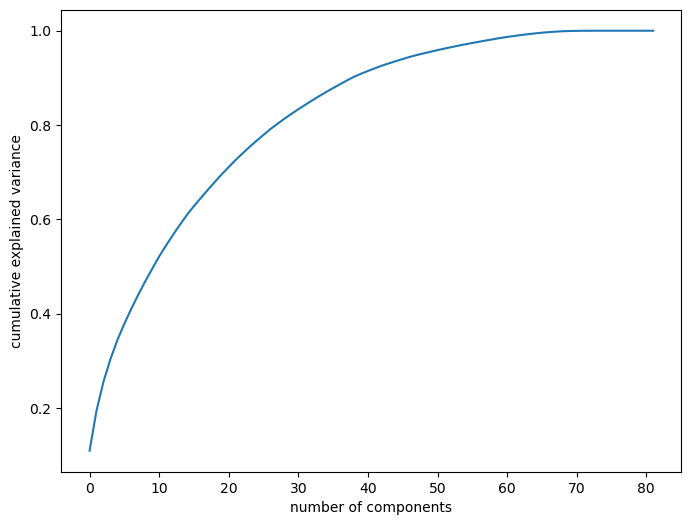

,PC1,PC2,PC3,Feature
0,0.003295,0.003640,-0.005005,id
1,0.049261,0.319631,0.113330,arpu_8
2,-0.082087,0.138639,0.149792,onnet_mou_8
3,-0.067617,0.229695,0.075803,offnet_mou_8
4,0.000553,0.043895,0.004392,roam_ic_mou_8


In [1057]:
pca = get_scree_plot(X_scaled) # scree plot

col = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head()

In [1058]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.93,  19.47,  25.59,  30.38,  34.42,  37.86,  41.04,  44.02,
        46.85,  49.52,  52.13,  54.47,  56.74,  58.88,  60.96,  62.81,
        64.55,  66.27,  67.93,  69.57,  71.1 ,  72.61,  74.  ,  75.37,
        76.67,  77.92,  79.15,  80.25,  81.34,  82.36,  83.35,  84.29,
        85.22,  86.13,  87.  ,  87.85,  88.67,  89.47,  90.24,  90.88,
        91.48,  92.05,  92.6 ,  93.09,  93.57,  94.02,  94.46,  94.85,
        95.21,  95.56,  95.91,  96.23,  96.54,  96.84,  97.14,  97.41,
        97.68,  97.95,  98.21,  98.47,  98.7 ,  98.9 ,  99.1 ,  99.28,
        99.45,  99.6 ,  99.72,  99.82,  99.92,  99.96, 100.  , 100.02,
       100.03, 100.03, 100.03, 100.03, 100.03, 100.03, 100.03, 100.03,
       100.03, 100.03])

#### Observation : Looks like 60 components are enough to describe 95% of the variance in the dataset.We'll choose **60** components for our modeling

## Model Prediction and Evaluation

In [1059]:
unseen.shape

(30000, 171)

In [1060]:
telecom_pca_df.shape

(20984, 83)

In [1061]:
x_train=X
y_train=Y

In [1062]:
X.columns


Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_t2c_mou_8',
       'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_t2o_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8',
       'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8',
       'total_rech_data_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8',
       'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon',
       'vbc_3g_8', 'churn_probability', 'total_rech_amt_data_8',
       'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67',
       'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'av

In [1063]:
unseen['total_rech_data_6'] = unseen['total_rech_data_6'].replace(np.nan,0.0)
unseen['total_rech_data_7'] = unseen['total_rech_data_7'].replace(np.nan,0.0)
unseen['total_rech_data_8'] = unseen['total_rech_data_8'].replace(np.nan,0.0)
unseen['av_rech_amt_data_6'] = unseen['av_rech_amt_data_6'].replace(np.nan,0.0)
unseen['av_rech_amt_data_7'] = unseen['av_rech_amt_data_7'].replace(np.nan,0.0)
unseen['av_rech_amt_data_8'] = unseen['av_rech_amt_data_8'].replace(np.nan,0.0)
# let's adding new column total recharge amount for data: total_rech_amt_data for calculating High Value customer process
unseen['total_rech_amt_data_6'] = unseen.av_rech_amt_data_6 + data.total_rech_data_6
unseen['total_rech_amt_data_7'] = unseen.av_rech_amt_data_7 + data.total_rech_data_7
unseen['total_rech_amt_data_8'] = unseen.av_rech_amt_data_8 + data.total_rech_data_8
unseen['total_avg_rech_amnt_6_7_GPhase'] = (unseen.total_rech_amt_6 + unseen.total_rech_amt_data_6 \
                                               + unseen.total_rech_amt_7+ unseen.total_rech_amt_data_7)/2

In [1064]:
unseen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 175 entries, id to total_avg_rech_amnt_6_7_GPhase
dtypes: float64(139), int64(27), object(9)
memory usage: 40.1+ MB


In [1065]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = unseen.total_avg_rech_amnt_6_7_GPhase.quantile(0.7)
test_data_high_val_cust = unseen

In [1066]:
drop_col_with_unique_col =['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 
                          'last_date_of_month_6', 'last_date_of_month_7',
                          'std_og_t2c_mou_6', 'std_og_t2c_mou_7','std_ic_t2o_mou_6', 
                          'std_ic_t2o_mou_7']

print("Features before dropping unique values : "+ str(test_data_high_val_cust.shape[1]))
test_data_high_val_cust.drop(drop_col_with_unique_col,axis=1,inplace=True)
print("Features after dropping unique values : "+ str(test_data_high_val_cust.shape[1]))

Features before dropping unique values : 175
Features after dropping unique values : 165


In [1067]:
test_data_high_val_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 165 entries, id to total_avg_rech_amnt_6_7_GPhase
dtypes: float64(132), int64(26), object(7)
memory usage: 37.8+ MB


In [1068]:
for col in df_DateCols:
    test_data_high_val_cust[col] = pd.to_datetime(test_data_high_val_cust[col])
test_data_high_val_cust.head()

,id,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase
0,69999,2014-08-31,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,...,NaN,NaN,1692,0.00,0.00,0.00,0.0,0.0,0.0,96.5
1,70000,2014-08-31,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,...,NaN,NaN,2533,0.00,0.00,0.00,0.0,1.0,0.0,500.5
2,70001,2014-08-31,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,...,NaN,NaN,277,525.61,758.41,241.84,0.0,0.0,0.0,750.0
3,70002,2014-08-31,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,...,NaN,NaN,1244,0.00,0.00,0.00,0.0,0.0,0.0,185.0
4,70003,2014-08-31,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,...,NaN,NaN,462,0.00,0.00,0.00,7.0,7.0,6.0,430.0


In [1069]:
#list_potential_categorical_type(get_meta_data(test_data_high_val_cust),test_data_high_val_cust)
test_data_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()
#Getting the last day recharge amount columns
last_day_rech_amt = test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('day')]
last_day_rech_amt.tolist()
usage_2g_and_3g = test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('2g|3g',regex=True)]
usage_2g_and_3g

Index(['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'vol_2g_mb_6',
       'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6',
       'arpu_2g_7', 'arpu_2g_8', 'monthly_2g_6', 'monthly_2g_7',
       'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8',
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object')

In [1070]:
# let's check Volume based cost 
vbc_column =test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('vbc_',regex=True)]
vbc_column.tolist()
# Renaming month named vbc columns to 6,7,8,9 format
test_data_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'}, inplace=True)

vbc_column = test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('vbc_3g',regex=True)]
vbc_column.tolist()

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']

In [1071]:
# Checking Service schemes with validity smaller than a month for 2G/3G
SC_2g_or_3g_col = test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('sachet_2g|sachet_3g',regex=True)]
# Checking columns for average revenue per user
arpu_cols = test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('arpu_')]
mou_cols = test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('mou')]
test_data_high_val_cust.loc[:,mou_cols] = test_data_high_val_cust.loc[:,mou_cols].replace(np.nan,0)
mou_og_cols6 = test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('.*_og_.*mou_6',regex=True)]

In [1072]:
list_total_og_cols = test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
test_data_high_val_cust.drop(list_total_og_cols,axis=1,inplace=True)
#log("Columns dropped - ")
list_total_og_cols.tolist()
mou_ic_cols6 = test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('.*_ic_.*mou_6',regex=True)]
test_data_high_val_cust.loc[:,mou_ic_cols6].describe()
list_total_ic_cols = test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
test_data_high_val_cust.drop(list_total_ic_cols,axis=1,inplace=True)
#log("Columns dropped - ")
list_total_ic_cols.tolist()
offnet_usage_service_col = test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('offnet.*mou',regex=True)]
#minutes of usage related columns
onnet_usage_service =test_data_high_val_cust.columns[test_data_high_val_cust.columns.str.contains('^onnet.*mou',regex=True)]
onnet_usage_service

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8'], dtype='object')

In [1073]:
test_data_high_val_cust


,id,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase
0,69999,2014-08-31,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,...,NaN,NaN,1692,0.00,0.00,0.00,0.0,0.0,0.0,96.5
1,70000,2014-08-31,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,...,NaN,NaN,2533,0.00,0.00,0.00,0.0,1.0,0.0,500.5
2,70001,2014-08-31,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,...,NaN,NaN,277,525.61,758.41,241.84,0.0,0.0,0.0,750.0
3,70002,2014-08-31,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,...,NaN,NaN,1244,0.00,0.00,0.00,0.0,0.0,0.0,185.0
4,70003,2014-08-31,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,...,NaN,NaN,462,0.00,0.00,0.00,7.0,7.0,6.0,430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,99994,2014-08-31,718.870,396.259,406.150,324.46,250.01,285.41,190.36,166.14,...,NaN,NaN,1255,3.71,105.64,61.48,125.0,0.0,1.0,676.5
29996,99995,2014-08-31,218.327,324.070,374.981,263.79,467.24,650.26,108.53,124.11,...,0.0,NaN,2258,0.00,0.00,0.00,1.0,177.0,0.0,396.5
29997,99996,2014-08-31,139.473,38.230,180.194,11.08,14.89,19.94,37.24,16.74,...,NaN,NaN,440,0.00,0.00,0.00,0.0,0.0,1.0,75.0
29998,99997,2014-08-31,1122.912,781.121,257.439,122.74,50.23,26.46,1854.09,1088.83,...,NaN,NaN,810,0.00,0.00,0.00,0.0,0.0,0.0,1081.0


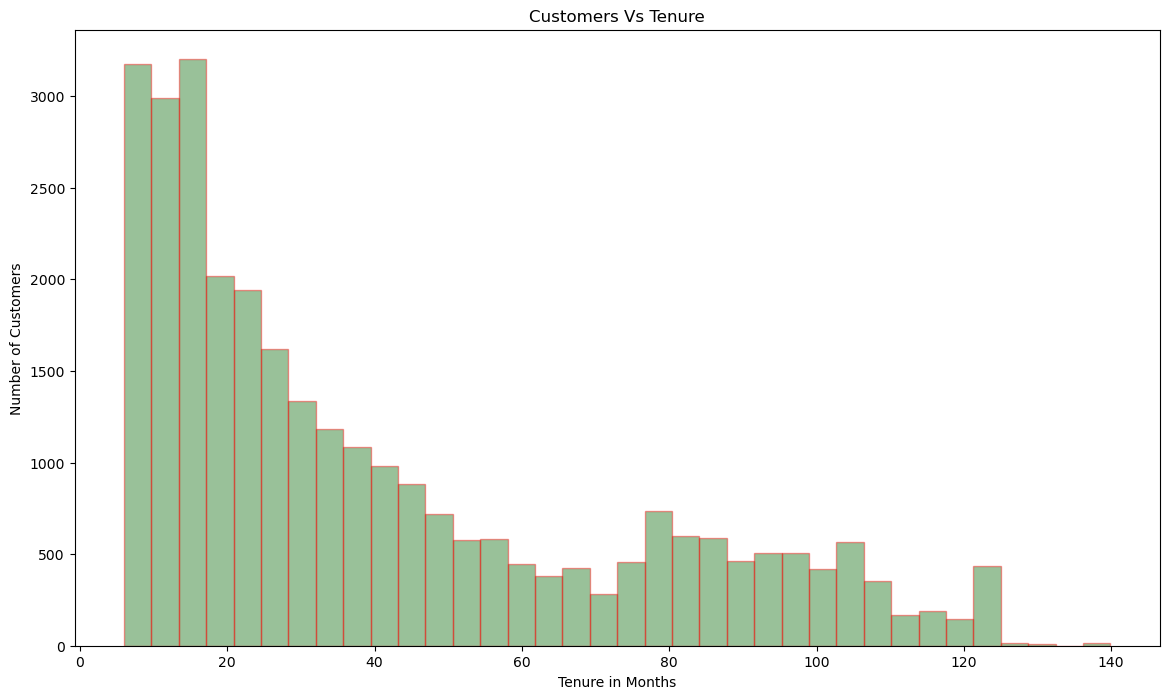

(30000, 147)
(30000, 139)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
count_rech_2g
count_rech_3g
av_rech_amt_data
vol_2g_mb
vol_3g_mb
arpu_3g
arpu_2g
night_pck_user
monthly_2g
sachet_2g
monthly_3g
sachet_3g
fb_user
vbc_3g
total_rech_amt_data


In [1074]:
tenure_data = test_data_high_val_cust.copy()
plt.figure(figsize=(14,8))
# aon --> Age on network - number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()
ax = sns.distplot(tenure_data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

numberic_col = [ 'og_others_6','ic_others_6', 'og_others_7', 'ic_others_7']

test_data_final = test_data_high_val_cust.copy()
print(test_data_final.shape)
test_data_final.head(3)
test_data_final.drop(["total_avg_rech_amnt_6_7_GPhase"],axis=1,inplace=True)
test_data_final.drop(test_data_high_val_cust.filter(regex='date_').columns,axis=1,inplace=True)
print (test_data_final.shape)

col_list = test_data_final.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    test_data_final[avg_col_name] = (test_data_final[col_6]  + test_data_final[col_7])/ 2

In [1075]:
test_x=test_data_final[['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_t2c_mou_8',
       'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_t2o_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8',
       'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8',
       'total_rech_data_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8',
       'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon',
       'vbc_3g_8', 'total_rech_amt_data_8',
       'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67',
       'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_loc_og_t2f_mou_av67', 'avg_loc_og_t2c_mou_av67',
       'avg_std_og_t2t_mou_av67', 'avg_std_og_t2m_mou_av67',
       'avg_std_og_t2f_mou_av67', 'avg_isd_og_mou_av67', 'avg_spl_og_mou_av67',
       'avg_og_others_av67', 'avg_loc_ic_t2t_mou_av67',
       'avg_loc_ic_t2m_mou_av67', 'avg_loc_ic_t2f_mou_av67',
       'avg_std_ic_t2t_mou_av67', 'avg_std_ic_t2m_mou_av67',
       'avg_std_ic_t2f_mou_av67', 'avg_spl_ic_mou_av67', 'avg_isd_ic_mou_av67',
       'avg_ic_others_av67', 'avg_total_rech_num_av67',
       'avg_total_rech_amt_av67', 'avg_max_rech_amt_av67',
       'avg_last_day_rch_amt_av67', 'avg_total_rech_data_av67',
       'avg_max_rech_data_av67', 'avg_av_rech_amt_data_av67',
       'avg_vol_2g_mb_av67', 'avg_vol_3g_mb_av67', 'avg_monthly_2g_av67',
       'avg_sachet_2g_av67', 'avg_monthly_3g_av67', 'avg_sachet_3g_av67',
       'avg_vbc_3g_av67', 'avg_total_rech_amt_data_av67']]

In [1076]:
test_x.shape

(30000, 81)

In [1077]:
X.columns

Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_t2c_mou_8',
       'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_t2o_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8',
       'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8',
       'total_rech_data_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8',
       'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon',
       'vbc_3g_8', 'churn_probability', 'total_rech_amt_data_8',
       'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67',
       'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'av

In [1078]:
X=X.replace(np.nan,0)

In [1079]:
x_train=X
y_train=Y
x_test=test_x

In [1080]:
x_train.shape

(20984, 82)

In [1081]:
x_test.shape

(30000, 81)

In [1082]:
X_train=x_train.drop(['churn_probability'],axis=1)

In [1083]:
y_train.head()

12    0
15    0
23    0
24    0
27    0
Name: churn, dtype: int64

In [1084]:
y_train.shape

(20984,)

## Tree Model Regression 

In [1085]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [1086]:
rfc = RandomForestClassifier()

In [1087]:
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [1088]:
x_test=x_test.replace(np.nan,0)

In [1089]:
x_test.shape

(30000, 81)

In [1090]:
# Making predictions
predictions = rfc.predict(x_test)

In [1091]:
predictions

array([0, 0, 1, ..., 0, 0, 0])

### Hyperparameter Tuning

In [1092]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report


def tune_hyperparameter(parameters,x_train,y_train,n_folds = 5,max_depth=0):
    
    if(max_depth==0):
        rf = RandomForestClassifier()
    else :
        rf = RandomForestClassifier(max_depth=max_depth)
        
    rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
    rf.fit(x_train, y_train)
    scores = rf.cv_results_

    for key in parameters.keys():
        hyperparameters = key
        break

    # plotting accuracies for parameters
    plt.figure(figsize=(16,5))
    plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
    plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
    plt.xlabel(hyperparameters)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

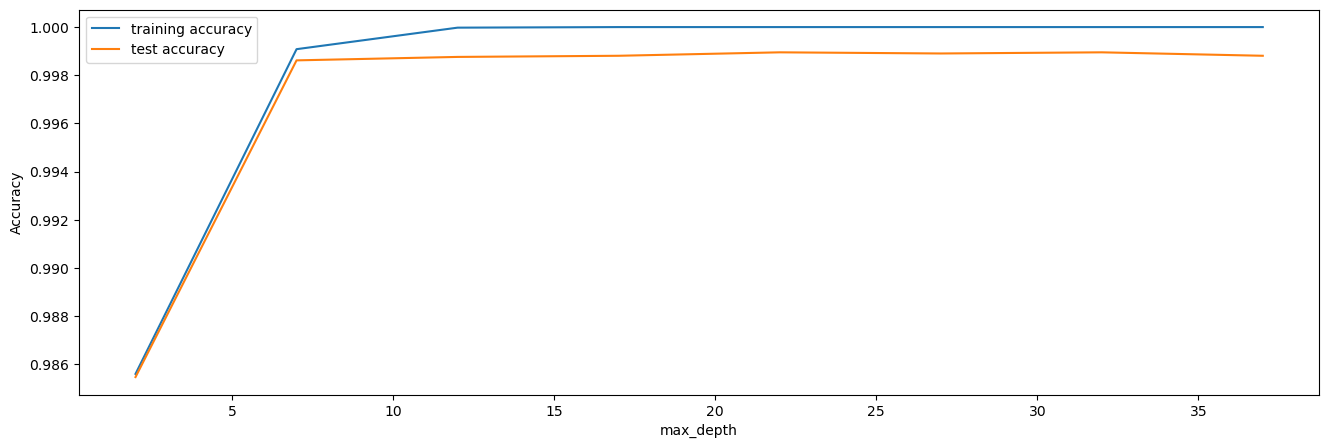

In [1093]:
# parameters to build the model on
parameters = {'max_depth': range(2, 40, 5)}
tune_hyperparameter(parameters,x_train,y_train)

#### Observation :
- We can see that as we increase the value of max_depth, both train and test scores increase till a point, but after that test score becomme stagnant. 
- The ensemble tries to overfit as we increase the max_depth. Thus, controlling the depth of the constituent trees will help reduce overfitting in the forest.
- **7 and 12** value have peek convergens and can be used for grid veiw search.

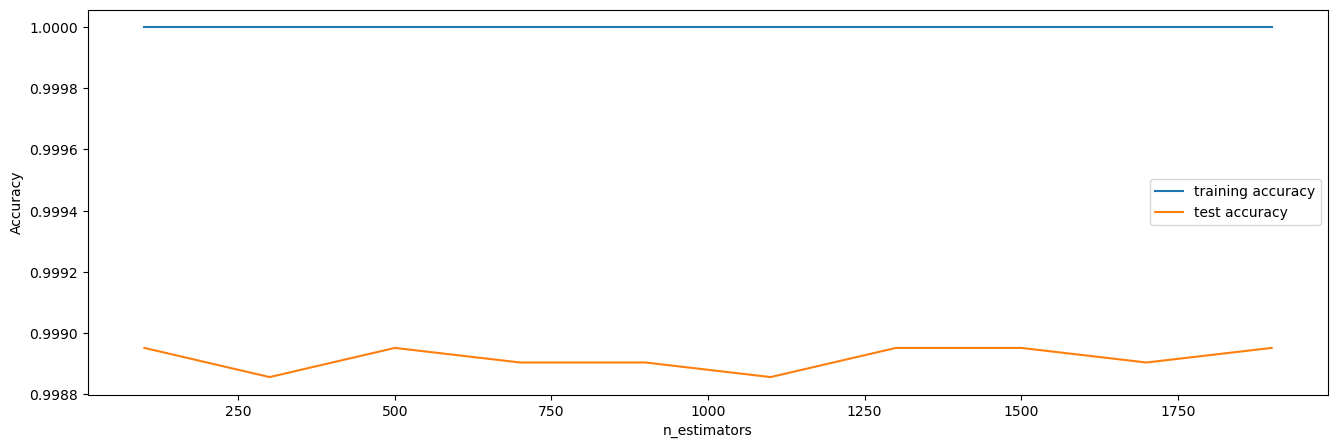

In [1094]:
# parameters to build the model on
parameters = {'n_estimators': range(100, 2000, 200)}
tune_hyperparameter(parameters,x_train,y_train)

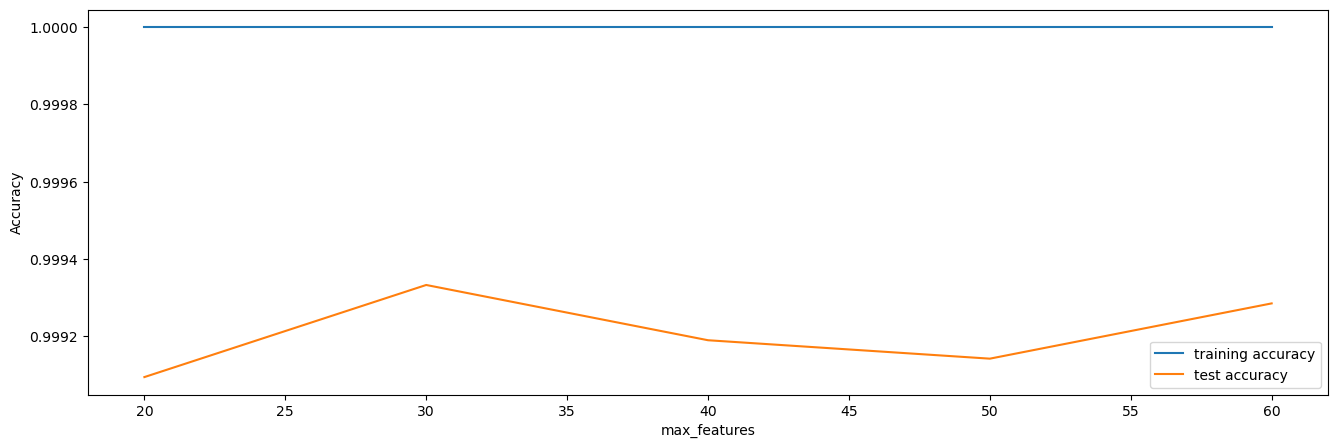

In [1095]:
# parameters to build the model on
parameters = {'max_features': [20,30,40,50,60]}
tune_hyperparameter(parameters,x_train,y_train,4)

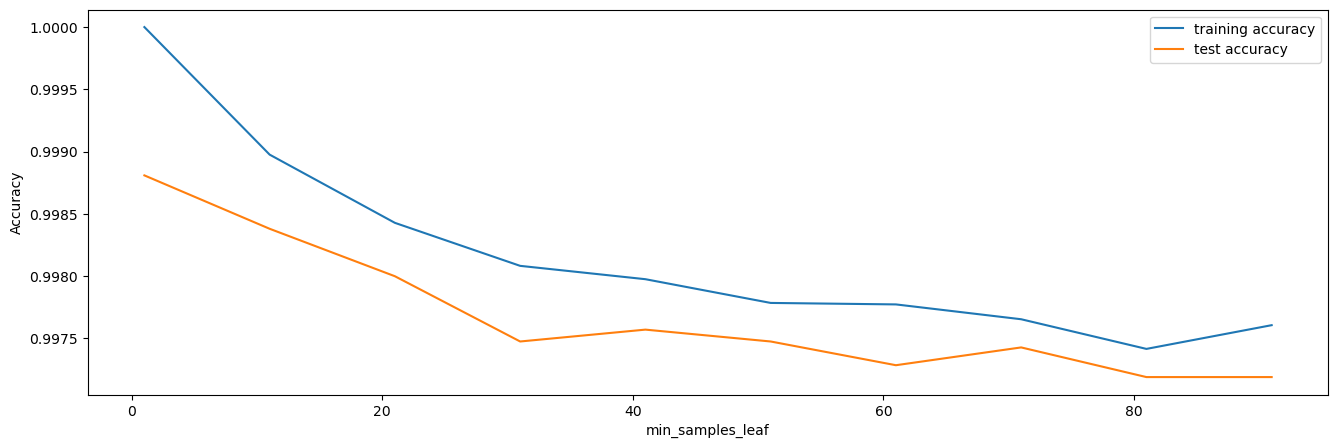

In [1096]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(1, 100, 10)}
tune_hyperparameter(parameters,x_train,y_train)

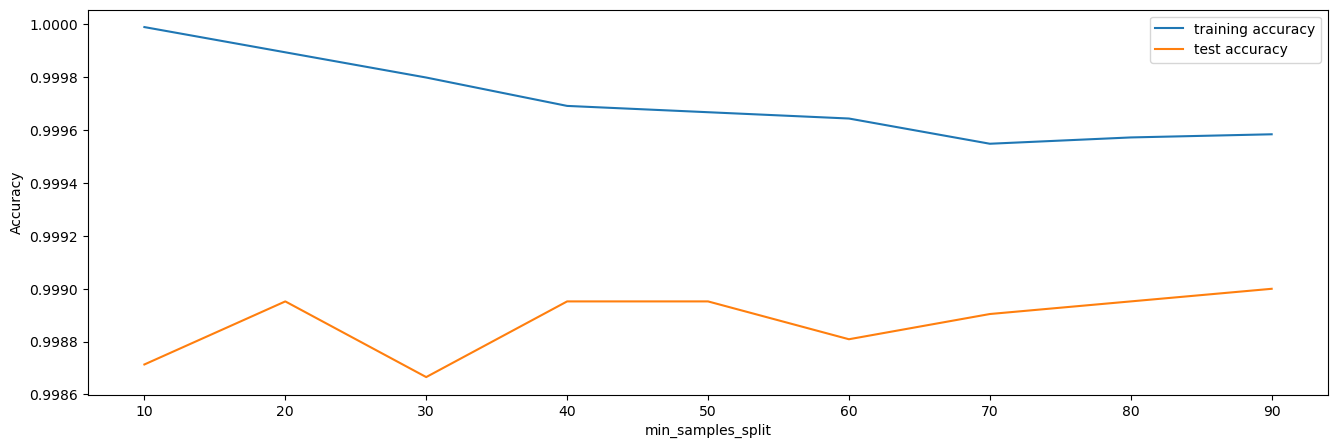

In [1097]:
# parameters to build the model on
parameters = {'min_samples_split': range(10, 100, 10)}
tune_hyperparameter(parameters,x_train,y_train)

#### Grid Search to Find Optimal Hyperparameters

In [1098]:
#We can now find the optimal hyperparameters using GridSearchCV.
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [7,12],
    'n_estimators': [200],
    'max_features': [40],
    'min_samples_leaf': [10,20],
    'min_samples_split': [10,20,30]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1,return_train_score=True)

In [1099]:
# Fit the grid search to the data
rf_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [7, 12], 'max_features': [40],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [200]},
             return_train_score=True, verbose=1)

In [1100]:
#printing the optimal accuracy score and hyperparameters
print('We can get accuracy of '+str(round(rf_grid_search.best_score_,2))+' using '+str(rf_grid_search.best_params_))

We can get accuracy of 1.0 using {'max_depth': 12, 'max_features': 40, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}


In [1101]:
print("Max accuracy with Random Forest classifier - "+str(round(rf_grid_search.best_score_,2)))

Max accuracy with Random Forest classifier - 1.0


## Building and Evaluating the Final Model for Random Forest
- Let's now build and evaluate the final model, i.e. the model with highest test accuracy.

In [1102]:
rfc = RandomForestClassifier(max_depth=12,
                             max_features=40,
                             min_samples_leaf=10,
                             min_samples_split=10,
                             n_estimators=200,
                             n_jobs = -1)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=12, max_features=40, min_samples_leaf=10,
                       min_samples_split=10, n_estimators=200, n_jobs=-1)

In [1103]:
# Making predictions
predictions = rfc.predict(x_test)

In [1104]:
predictions

array([0, 0, 1, ..., 0, 0, 0])

In [1105]:
solution_data=pd.DataFrame(predictions,index=unseen['id'],columns=['churn_probability'])

In [1106]:
type(solution_data)

pandas.core.frame.DataFrame

In [1107]:
solution_data

,churn_probability
id,
69999,0
70000,0
70001,1
70002,0
70003,0
...,...
99994,0
99995,0
99996,0


In [1108]:
solution_data.to_csv("Submission.csv")